In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats as sts
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold, mutual_info_classif, f_classif

### Data import

In [2]:
data = load_breast_cancer(as_frame=True)

### Data preparation

In [3]:
# (separate) X and y
X = data.data
y = data.target

In [4]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101, shuffle=True)

##### To avoid information leakage, feature selection will be performed only on the training set.

### Feature selection

- Variance threshold

In [5]:
# remove features with a low variance
selector = VarianceThreshold(threshold=.25)   # drop features in which similarity is 75% or higher
selection = selector.fit(X_train)   # fit the selector
sel_index = selection.get_support()   # get the results for the features
selected_features_VT = X_train.columns[sel_index]   # get the names of the selected features

In [6]:
selected_features_VT

Index(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'texture error', 'perimeter error', 'area error', 'worst radius',
       'worst texture', 'worst perimeter', 'worst area'],
      dtype='object')

<br>

#### Univariate feature selection

- Correlation analysis

In [7]:
# calculate correlation coefficient and p-value with point biserial correlation
feature_list = []
PB_corr = []
PB_sign = []

for c in X_train.columns:
    feature_list.append(c)   # add feature names to the list
    PB_corr.append(sts.pointbiserialr(y_train, X_train[c])[0])   # only the correlation coefficients
    PB_sign.append(sts.pointbiserialr(y_train, X_train[c])[1])   # only the p-values

# create a df with the correlation results
correlation_df = pd.DataFrame({'feature':feature_list, 'correlation':PB_corr, 'significance':PB_sign})   # create a df with the results
correlation_df.set_index('feature', inplace=True)   # set feature names as index for the heatmap

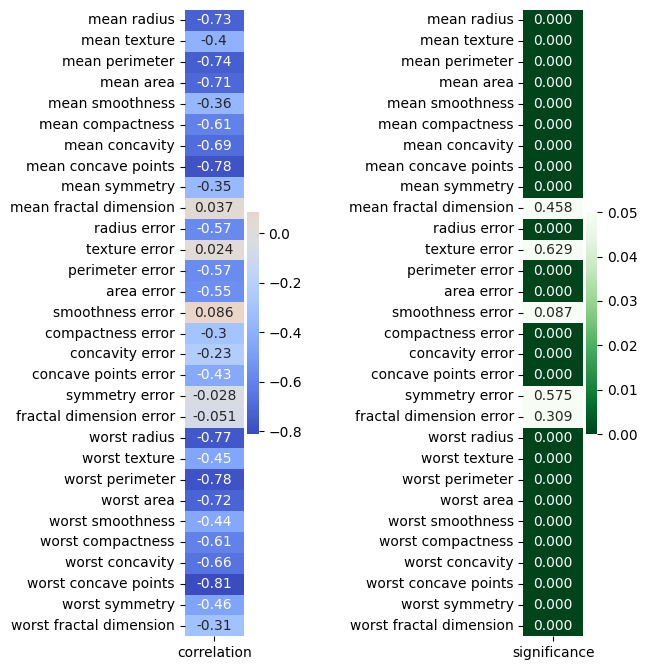

In [8]:
# visualize the correlation results
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9,11), width_ratios=(1,1))
fig.tight_layout(pad=16)

# correlation heatmap
sns.heatmap(data=correlation_df[['correlation']], annot=True, cmap='coolwarm', center=0, ax=ax[0])
ax[0].set_ylabel('')

# significance heatmap
sns.heatmap(data=correlation_df[['significance']], annot=True, fmt='.3f', cmap='Greens_r', vmax=0.05, ax=ax[1])
ax[1].set_ylabel('');

##### In most cases, significance is very high, therefore selecting all the significant features wouldn't drasticly reduce the number of features.

In [9]:
# select features with a relativily high correlation
selected_features_PBcorr = correlation_df[correlation_df['correlation'].abs() > 0.65]   # selection
selected_features_PBcorr = selected_features_PBcorr.sort_values('correlation')   # ordering

In [10]:
selected_features_PBcorr

,correlation,significance
feature,,
worst concave points,-0.812227,9.958450e-95
mean concave points,-0.783217,9.542099e-84
worst perimeter,-0.777190,1.121979e-81
worst radius,-0.770776,1.523739e-79
mean perimeter,-0.744040,2.379762e-71
mean radius,-0.731126,9.496150e-68
worst area,-0.719659,1.009960e-64
mean area,-0.708127,7.924300e-62
mean concavity,-0.689095,2.394478e-57


- Mutual information score

In [11]:
# select features with high mutual information
MIscores = mutual_info_classif(X_train, y_train, random_state=101)
MI_results = pd.DataFrame({'feature':X_train.columns, 'MI_score':MIscores})   # create a df with the MI scores

# calculate median MI score
MI_median = MI_results['MI_score'].median()

# features that have a MI score higher then the median
selected_features_MI = MI_results[MI_results['MI_score'] > MI_median]   # selection
selected_features_MI = selected_features_MI.sort_values('MI_score', ascending=False)   # descending order

In [12]:
selected_features_MI

,feature,MI_score
22,worst perimeter,0.480664
27,worst concave points,0.468007
23,worst area,0.462424
20,worst radius,0.458436
7,mean concave points,0.441503
2,mean perimeter,0.413537
0,mean radius,0.385695
3,mean area,0.382068
6,mean concavity,0.367583
26,worst concavity,0.350864


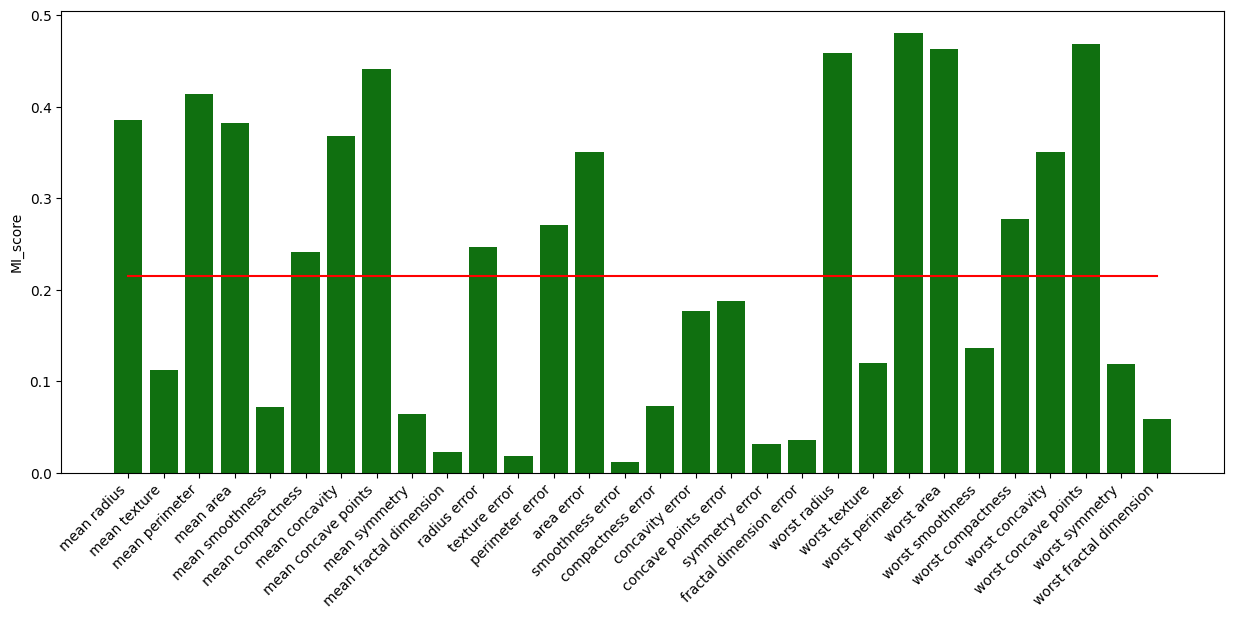

In [13]:
# visualize the above results
plt.figure(figsize=(15,6))
sns.barplot(data=MI_results, x='feature', y='MI_score', color='green')
sns.lineplot(data=MI_results, x='feature', y=MI_results['MI_score'].median(), c='red')   # to show the median MI score
plt.xticks(rotation=45, ha='right')
plt.xlabel('');

- F-score

In [14]:
# feature selection via F-scores
Fscores = f_classif(X_train, y_train)
Fscore_results = pd.DataFrame({'feature':X.columns, 'F_score':Fscores[0], 'p_value':Fscores[1]})   # create a df with the F-scores

In [15]:
# number of features that are significant
len(Fscore_results[Fscore_results['p_value'] < 0.0001])

25

In [16]:
# features that are insignificant
Fscore_results[Fscore_results['p_value'] > 0.05]

,feature,F_score,p_value
9,mean fractal dimension,0.551365,0.458201
11,texture error,0.234402,0.628547
14,smoothness error,2.944166,0.086970
18,symmetry error,0.315327,0.574747
19,fractal dimension error,1.037529,0.309019


##### Since most of the features show very strong significance, the number of features cannot be reduced based on this parameter.
##### There are 5 insignificant features that are exactly the same as the ones in the correlation test.

In [17]:
# calculate median F-score
Fscore_median = Fscore_results['F_score'].median()

# select features with an F-score higher then the median
selected_features_Fscore = Fscore_results[Fscore_results['F_score'] > Fscore_median]   # selection
selected_features_Fscore = selected_features_Fscore.sort_values('F_score', ascending=False)   # descending order

In [18]:
selected_features_Fscore

,feature,F_score,p_value
27,worst concave points,767.720439,9.958450e-95
7,mean concave points,628.391414,9.542099e-84
22,worst perimeter,604.060947,1.121979e-81
20,worst radius,579.600781,1.523739e-79
2,mean perimeter,491.088539,2.379762e-71
0,mean radius,454.781585,9.496150e-68
23,worst area,425.420961,1.009960e-64
3,mean area,398.294193,7.924300e-62
6,mean concavity,358.072346,2.394478e-57
26,worst concavity,302.956310,8.423243e-51


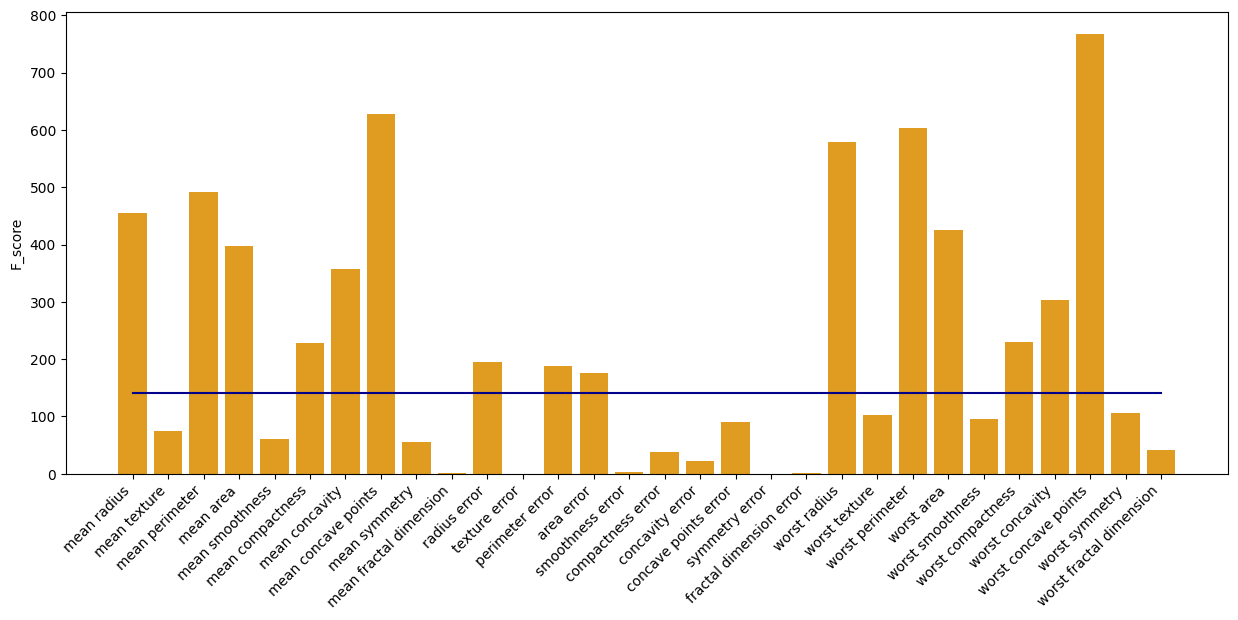

In [19]:
# visualize the above results
plt.figure(figsize=(15,6))
sns.barplot(data=Fscore_results, x='feature', y='F_score', color='orange')
sns.lineplot(data=Fscore_results, x='feature', y=Fscore_results['F_score'].median(), c='darkblue')   # to show the median MI score
plt.xticks(rotation=45, ha='right')
plt.xlabel('');

<br>

#### Beyond univariate feature selection - model-based methods to evaluate feature importance